##  Credit Risk Modelling 

This notebook covers training and evaluating different models to predict loan defaults

In [ ]:
import pandas as pd
import numpy as np
from credit_risk_model.data_cleaning import clean_all
from credit_risk_model.feat_eng import engineer_features
from credit_risk_model.model import(
     train_logistic_regression,
     train_xgboost, train_lightgbm,
    compare_models,hyperparameter_tuning_xgboost, 
    hyperparameter_tuning_lightgbm,
    compare_tuned_and_baseline_models
)
from credit_risk_model.config import DATA_PROCESSED, MODELS_DIR

# Import necessary libraries for modelling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, 
    classification_report,
    confusion_matrix
)
import joblib

In [2]:
df = pd.read_csv(DATA_PROCESSED/"agg_main.csv")

In [3]:
df.head()

,target,credit_income_ratio,total_income,total_credit_requested,monthly_loan_payment,value_of_goods_financed,age_years,employment_years,NAME_CONTRACT_TYPE,CODE_GENDER,...,avg_amt_credit,approval_rate,n_active_contracts,avg_months_active,n_completed_contracts,avg_payment_ratio,installments_n_late_payments,avg_balance,max_balance,avg_utilization
0,0,2.857143,157500.0,450000.0,35685.0,450000.0,59.309589,12.909589,Cash loans,F,...,443773.607143,0.428571,34.0,-34.794118,5.0,1.056709,2.0,29452.900500,158449.500,NaN
1,0,1.200000,112500.0,135000.0,7879.5,135000.0,48.030137,0.441096,Cash loans,F,...,170367.750000,0.750000,59.0,-26.881356,4.0,1.000000,0.0,0.000000,0.000,0.000000
2,0,6.040000,112500.0,679500.0,19867.5,679500.0,37.117808,5.468493,Cash loans,F,...,145647.750000,0.833333,35.0,-28.428571,3.0,0.897436,7.0,0.000000,0.000,0.000000
3,0,2.900000,225000.0,652500.0,47610.0,652500.0,38.049315,6.347945,Cash loans,M,...,167734.500000,1.000000,24.0,-29.000000,2.0,0.941860,3.0,279583.392414,463463.865,0.759396
4,0,0.733333,135000.0,99000.0,10395.0,99000.0,27.446575,1.038356,Cash loans,F,...,146957.785714,1.000000,49.0,-47.367347,4.0,0.979031,16.0,193191.533710,463813.695,0.674371


## split data

splitting is done so early here to avoid leakage of information from the validation set into the training process, since cleaning uses data level statistics 


In [4]:
# split
X = df.drop('target', axis=1)
y = df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


In [5]:
#clean data
X_train = clean_all(X_train)
X_val = clean_all(X_val)

In [6]:
# feature engineering
X_train = engineer_features(X_train)
X_val = engineer_features(X_val)

# Replace infinity with 0
X_train = X_train.replace([np.inf, -np.inf], 0)
X_val = X_val.replace([np.inf, -np.inf], 0)

#save processed data
X_train.to_csv(DATA_PROCESSED/"feature_engineered.csv", index=False)
X_val.to_csv(DATA_PROCESSED/"feature_engineered_val.csv", index=False)
y_val.to_csv(DATA_PROCESSED/"target_val.csv", index=False)
y_train.to_csv(DATA_PROCESSED/"target_train.csv", index=False)

## Evaluate models 

### Baseline model (Logistic Regression)
scaling is done here on only the continuous cols ommiting encoded cols and binary cols

NOTE: tree based models don't require scaling, it is only done here for logistic regression

In [7]:
log_reg_pipe, y_proba, y_pred = train_logistic_regression(
    X_train, y_train, X_val, y_val
)

print("="*50)
print("BASELINE MODEL PERFORMANCE (Logistic Regression)")
print("="*50)

print(f"\nROC-AUC Score: {roc_auc_score(y_val, y_proba):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

BASELINE MODEL PERFORMANCE (Logistic Regression)

ROC-AUC Score: 0.6980

Confusion Matrix:
[[36284 20254]
 [ 1725  3240]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.64      0.77     56538
           1       0.14      0.65      0.23      4965

    accuracy                           0.64     61503
   macro avg       0.55      0.65      0.50     61503
weighted avg       0.89      0.64      0.72     61503



### XGBoost

In [8]:
xgb_model, y_proba_xgb, y_pred_xgb = train_xgboost(
    X_train, y_train, X_val, y_val
)

print("="*50)
print("XGBoost Performance")
print("="*50)
print(f"ROC-AUC: {roc_auc_score(y_val, y_proba_xgb):.4f}")
print("\n", classification_report(y_val, y_pred_xgb))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_xgb))

XGBoost Performance
ROC-AUC: 0.7223

               precision    recall  f1-score   support

           0       0.94      0.90      0.92     56538
           1       0.22      0.32      0.26      4965

    accuracy                           0.86     61503
   macro avg       0.58      0.61      0.59     61503
weighted avg       0.88      0.86      0.87     61503


Confusion Matrix:
[[50994  5544]
 [ 3369  1596]]


### Lightboost 

In [9]:
lgbm_model, y_proba_lgbm, y_pred_lgbm = train_lightgbm(
    X_train, y_train, X_val, y_val
)

print("="*50)
print("LightGBM Performance")
print("="*50)
print(f"ROC-AUC: {roc_auc_score(y_val, y_proba_lgbm):.4f}")
print("\n", classification_report(y_val, y_pred_lgbm))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_lgbm))

LightGBM Performance
ROC-AUC: 0.7208

               precision    recall  f1-score   support

           0       0.94      0.90      0.92     56538
           1       0.22      0.32      0.26      4965

    accuracy                           0.86     61503
   macro avg       0.58      0.61      0.59     61503
weighted avg       0.88      0.86      0.87     61503


Confusion Matrix:
[[51058  5480]
 [ 3395  1570]]


### Compare results

In [10]:
results_df = compare_models(X_val, y_val, log_reg_pipe, xgb_model, lgbm_model)
results_df

,AUC-ROC,AUC-PR,Precision,Recall,F1-score,KS,Gini
XGBoost,0.722349,0.198046,0.223529,0.321450,0.263693,0.331434,0.444698
LightGBM,0.720771,0.196545,0.222695,0.316213,0.261340,0.328184,0.441542
LogisticRegression,0.698033,0.168851,0.081359,0.999194,0.150466,0.297453,0.396066


## Hyperparameter Tuning 

### Hyperparameter tuning for xgboost

In [11]:
xgb_tuned = hyperparameter_tuning_xgboost(X_train, y_train, X_val, y_val) 

[I 2025-12-04 21:34:51,756] A new study created in memory with name: no-name-bd2d755c-657f-4140-b4f4-49f1ca7ccaba
[I 2025-12-04 21:35:49,490] Trial 0 finished with value: 0.7195392919348382 and parameters: {'n_estimators': 886, 'max_depth': 7, 'learning_rate': 0.016075397142199695, 'subsample': 0.8797380322386976, 'colsample_bytree': 0.632475723257732, 'gamma': 5.3600554668557345, 'min_child_weight': 1, 'reg_alpha': 2.5748078702049364, 'reg_lambda': 1.9413407615623768}. Best is trial 0 with value: 0.7195392919348382.
[I 2025-12-04 21:36:19,769] Trial 1 finished with value: 0.7215878424075537 and parameters: {'n_estimators': 318, 'max_depth': 4, 'learning_rate': 0.05111618435892054, 'subsample': 0.980490815090993, 'colsample_bytree': 0.6151867309429693, 'gamma': 0.44720186707553844, 'min_child_weight': 5, 'reg_alpha': 4.985024816492253, 'reg_lambda': 4.36780150190144}. Best is trial 1 with value: 0.7215878424075537.
[I 2025-12-04 21:37:03,755] Trial 2 finished with value: 0.723050906738

### Hyperparameter tuning for LightGBM

In [19]:
lgbm_tuned = hyperparameter_tuning_lightgbm(X_train, y_train, X_val, y_val)

[I 2025-12-04 22:23:24,556] A new study created in memory with name: no-name-d9b55fd0-6b73-403c-bdff-af0e2ae3bd7a
[W 2025-12-04 22:23:24,565] Trial 0 failed with parameters: {'num_leaves': 75, 'max_depth': 1, 'learning_rate': 0.0064306480843931485, 'n_estimators': 500, 'subsample': 0.6267242544438316, 'colsample_bytree': 0.9602770470207571, 'min_child_samples': 121, 'reg_lambda': 1.1315420016643651, 'reg_alpha': 1.5522050385323576} because of the following error: NameError("name 'lgb' is not defined").
Traceback (most recent call last):
  File "c:\Users\hp\venv\Lib\site-packages\optuna\study\_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\hp\credit_risk\src\credit_risk_model\model.py", line 236, in objective_lgbm
    eval_metric="auc",
               ^^^
NameError: name 'lgb' is not defined
[W 2025-12-04 22:23:24,571] Trial 0 failed with value None.


NameError: name 'lgb' is not defined

## Compare all models(baseline and tuned)

In [ ]:
results_df = compare_tuned_and_baseline_models(X_val, y_val, log_reg_pipe, xgb_model, lgbm_model, xgb_tuned, lgbm_tuned)
print(results_df.to_string(index=False))

             Model  Baseline AUC  Tuned AUC
LogisticRegression      0.698033        NaN
           XGBoost      0.722349   0.727370
          LightGBM      0.720771   0.725473


0.7260147307283854


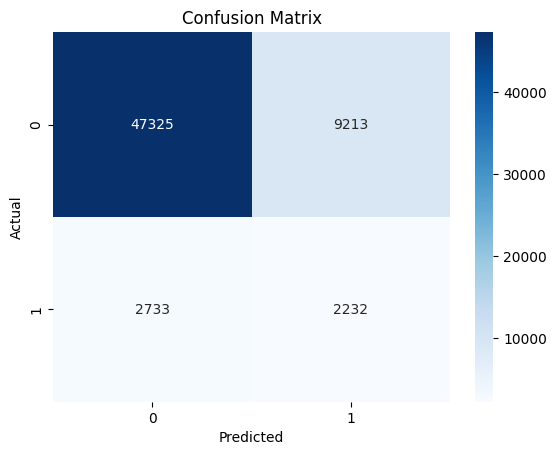


Confusion Matrix:
[[47325  9213]
 [ 2733  2232]]


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from credit_risk_model.config import RESULTS_DIR

# Get predictions
y_proba_xgbm_tuned = xgb_tuned.predict_proba(X_val)[:, 1]
y_pred_xgbm_tuned = (y_proba_xgbm_tuned >= 0.121).astype(int) 


print(roc_auc_score(y_val, y_proba_xgbm_tuned))


cm = confusion_matrix(y_val, y_pred_xgbm_tuned)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_xgbm_tuned))


# Confusion Matrix:
# [[56515    23]
#  [ 4942    23]]

In [ ]:
# Check probability distribution
probas = xgb_tuned.predict_proba(X_val)[:, 1]
print(f"Max prob: {probas.max()}")
print(f"Min prob: {probas.min()}")
print(f"Mean prob: {probas.mean()}")
print(f"Prob > 0.5: {(probas > 0.5).sum()}")
print(f"Prob > 0.3: {(probas > 0.3).sum()}")
print(f"Prob > 0.1: {(probas > 0.1).sum()}")

Max prob: 0.8243722319602966
Min prob: 0.0033552800305187702
Mean prob: 0.07948630303144455
Prob > 0.5: 61
Prob > 0.3: 900
Prob > 0.1: 15610


In [ ]:
y_proba_lgbm_tuned = lgbm_tuned.predict_proba(X_val)[:, 1]
y_pred_lgbm_tuned = (y_proba_lgbm_tuned >= 0.5).astype(int) 


print(roc_auc_score(y_val, y_proba_lgbm_tuned))


cm = confusion_matrix(y_val, y_pred_lgbm_tuned)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_lgbm_tuned))

AttributeError: 'tuple' object has no attribute 'predict_proba'

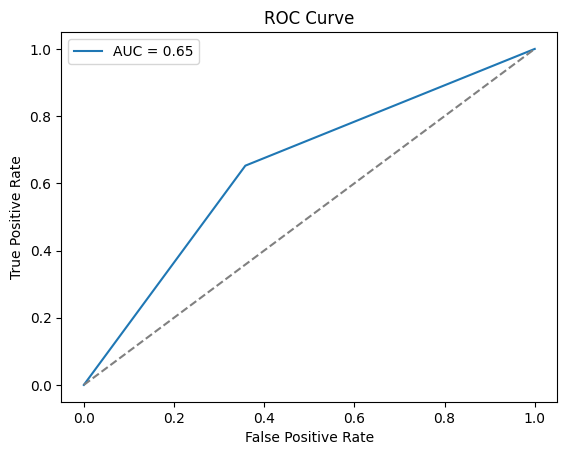

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
plt.savefig(f"{RESULTS_DIR}\\explainability\\roc_curve.png", dpi=300, bbox_inches="tight")

### Feature Importance

In [ ]:
# Get feature importances from tuned XGBoost model
importance = xgb_tuned.feature_importances_

feat_imp_df_xgb = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importance
}).sort_values("importance", ascending=False)

feat_imp_df_xgb.head(30)


,feature,importance
56,high_credit_utilization,0.119634
8,CODE_GENDER,0.053832
30,avg_utilization,0.042485
12,avg_debt_ratio,0.038920
18,n_refused,0.031475
57,bureau_activity_ratio,0.029781
7,NAME_CONTRACT_TYPE,0.029538
33,Core staff,0.028927
22,approval_rate,0.028925
53,has_many_active_loans,0.026836


### Save best model (XGBoost)

In [ ]:
all_models = {
    "log_reg": log_reg_pipe,
    "XGBoost": xgb_tuned,
    "LightGBM": lgbm_tuned,
}

for name, model in all_models.items():
    joblib.dump(model, f"{MODELS_DIR}/{name}.joblib")
